In [1]:
%load_ext autoreload
%autoreload 2

# Example of SasRec training/inference with Parquet Module

In [2]:
from typing import Optional

import lightning as L
import pandas as pd

L.seed_everything(42)

import warnings
warnings.filterwarnings("ignore")

Seed set to 42


## Preparing data
In this example, we will be using the MovieLens dataset, namely the 1m subset. It's demonstrated a simple case, so only item ids will be used as model input.

---
**NOTE**

Current implementation of SasRec is able to handle item and interactions features. It does not take into account user features. 

---

In [3]:
interactions = pd.read_csv("./data/ml1m_ratings.dat", sep="\t", names=["user_id", "item_id","rating","timestamp"])
interactions = interactions.drop(columns=["rating"])

In [4]:
interactions["timestamp"] = interactions["timestamp"].astype("int64")
interactions = interactions.sort_values(by="timestamp")
interactions["timestamp"] = interactions.groupby("user_id").cumcount()
interactions

,user_id,item_id,timestamp
1000138,6040,858,0
1000153,6040,2384,1
999873,6040,593,2
1000007,6040,1961,3
1000192,6040,2019,4
...,...,...,...
825793,4958,2399,446
825438,4958,1407,447
825724,4958,3264,448
825731,4958,2634,449


### Encode catagorical data.
To ensure all categorical data is fit for training, it needs to be encoded using the `LabelEncoder` class. Create an instance of the encoder, providing a `LabelEncodingRule` for each categorcial column in the dataset that will be used in model. Note that ids of users and ids of items are always used.

In [5]:
from replay.preprocessing.label_encoder import LabelEncoder, LabelEncodingRule

encoder = LabelEncoder(
    [
        LabelEncodingRule("user_id", default_value="last"),
        LabelEncodingRule("item_id", default_value="last"),
    ]
)
interactions = interactions.sort_values(by="item_id", ascending=True)
encoded_interactions = encoder.fit_transform(interactions)
encoded_interactions

,timestamp,user_id,item_id
0,12,0,0
1,68,1,0
2,67,2,0
3,12,3,0
4,140,4,0
...,...,...,...
1000204,14,4555,3705
1000205,90,2813,3705
1000206,70,2404,3705
1000207,25,5835,3705


### Split interactions into the train, validation and test datasets using LastNSplitter
We use widespread splitting strategy Last-One-Out. We filter out cold items and users for simplicity.

In [6]:
from replay.splitters import LastNSplitter

splitter = LastNSplitter(
    N=1,
    divide_column="user_id",
    query_column="user_id",
    strategy="interactions",
    drop_cold_users=True,
    drop_cold_items=True
)

test_events, test_gt = splitter.split(encoded_interactions)
validation_events, validation_gt = splitter.split(test_events)
train_events = validation_events

### Dataset preprocessing ("baking")
SasRec expects each user in the batch to provide their events in form of a sequence. For this reason, the event splits must be properly processed using the `groupby_sequences` function provided by RePlay.

In [7]:
from replay.data.nn.utils import groupby_sequences


def bake_data(full_data):
    grouped_interactions = groupby_sequences(events=full_data, groupby_col="user_id", sort_col="timestamp")
    return grouped_interactions

In [8]:
train_events = bake_data(train_events)

validation_events = bake_data(validation_events)
validation_gt = bake_data(validation_gt)

test_events = bake_data(test_events)
test_gt = bake_data(test_gt)

train_events

,user_id,timestamp,item_id
0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[2426, 822, 2733, 2587, 2937, 3618, 2943, 708,..."
1,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[3272, 3026, 2760, 851, 346, 3393, 1107, 515, ..."
2,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[579, 1140, 1154, 2426, 1524, 1260, 2160, 2621..."
3,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1781, 2940, 2468, 890, 948, 106, 593, 309, 49..."
4,4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1108, 2229, 21, 2435, 2142, 106, 1167, 593, 1..."
...,...,...,...
6035,6035,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[2426, 1279, 3151, 3321, 1178, 3301, 2501, 278..."
6036,6036,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1592, 2302, 1633, 1813, 2879, 1482, 2651, 250..."
6037,6037,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1971, 3500, 2077, 1666, 1399, 2651, 2748, 283..."
6038,6038,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1486, 1485, 3384, 3512, 3302, 3126, 3650, 330..."


To ensure we don't have unknown users in ground truth, we join validation events and validation ground truth (also join test events and test ground truth correspondingly) by user ids to leave only the common ones.  

In [9]:
def add_gt_to_events(events_df, gt_df):
    gt_to_join = gt_df[["user_id", "item_id"]].rename(columns={"item_id": "ground_truth"})

    events_df = events_df.merge(gt_to_join, on="user_id", how="inner")
    return events_df

validation_events = add_gt_to_events(validation_events, validation_gt)
test_events = add_gt_to_events(test_events, test_gt)

In [10]:
from pathlib import Path

data_dir = Path("temp/data/")
data_dir.mkdir(parents=True, exist_ok=True)

TRAIN_PATH = data_dir / "train.parquet"
VAL_PATH = data_dir / "val.parquet"
PREDICT_PATH = data_dir / "test.parquet"

ENCODER_PATH = data_dir / "encoder"

In [11]:
train_events.to_parquet(TRAIN_PATH)
validation_events.to_parquet(VAL_PATH)
test_events.to_parquet(PREDICT_PATH)

encoder.save(ENCODER_PATH)

# Prepare to model training
### Create the tensor schema
A schema shows the correspondence of columns from the source dataset with the internal representation of tensors inside the model. It is required by the SasRec model to correctly create embeddings for every source column. Note that user_id does not required in `TensorSchema`.

Note that the **padding value** is the next value (item_id) after the last one. **Cardinality** is the number of unique values ​​given the padding value.

In [12]:
from replay.data import FeatureHint, FeatureType
from replay.data.nn import TensorFeatureInfo, TensorSchema


EMBEDDING_DIM = 64

encoder = encoder.load(ENCODER_PATH)
NUM_UNIQUE_ITEMS = len(encoder.mapping["item_id"])

tensor_schema = TensorSchema(
    [
        TensorFeatureInfo(
            name="item_id",
            is_seq=True,
            padding_value=NUM_UNIQUE_ITEMS,
            cardinality=NUM_UNIQUE_ITEMS + 1,  # taking into account padding
            embedding_dim=EMBEDDING_DIM,
            feature_type=FeatureType.CATEGORICAL,
            feature_hint=FeatureHint.ITEM_ID,
        )
    ]
)

### Configure ParquetModule and transformation pipelines

The `ParquetModule` class enables training of models on large datasets by reading data in batch-wise way. This class initialized with **paths to every data split, a metadata dict containing information about shape and padding value of every column and a dict of transforms**. `ParquetModule`'s  "transform pipelines" are stage-specific modules implementing additional preprocessing to be performed on batch level right before the forward pass.  

For SasRec model, RePlay provides a function that generates a sequence of appropriate transforms for each data split named **make_default_sasrec_transforms**.

Internally this function creates the following transforms:
1) Training:
    1. Create a target, which contains the shifted item sequence that represents the next item in the sequence (for the next item prediction task).
    2. Rename features to match it with expected format by the model during training.
    3. Unsqueeze target (*positive_labels*) and it's padding mask (*target_padding_mask*) for getting required shape of this tensors for loss computation.
    4. Group input features to be embed in expected format.

2) Validation/Inference:
    1. Rename/group features to match it with expected format by the model during valdiation/inference.

If a different set of transforms is required, you can create them yourself and submit them to the ParquetModule in the form of a dictionary where the key is the name of the split, and the value is the list of transforms. Available transforms are in the replay/nn/transforms/.

**Note:** One of the transforms for the training data prepares the initial sequence for the task of Next Item Prediction so it shifts the sequence of items. For the final sequence length to be correct, you need to set shape of item_id in metadata as **model sequence length + shift**. Default shift value is 1.

In [13]:
from replay.nn.transform.template import make_default_sasrec_transforms

transforms = make_default_sasrec_transforms(tensor_schema, query_column="user_id")

In [14]:
MAX_SEQ_LEN = 50

def create_meta(shape: int, gt_shape: Optional[int] = None):
    meta = {
        "user_id": {},
        "item_id": {"shape": shape, "padding": tensor_schema["item_id"].padding_value},
    }
    if gt_shape is not None:
        meta.update({"ground_truth": {"shape": gt_shape, "padding": -1}})

    return meta

train_metadata = {
    "train": create_meta(shape=MAX_SEQ_LEN+1),
    "validate": create_meta(shape=MAX_SEQ_LEN, gt_shape=1),
}

In [15]:
from replay.data.nn import ParquetModule

BATCH_SIZE = 128

parquet_module = ParquetModule(
    train_path=TRAIN_PATH,
    validate_path=VAL_PATH,
    batch_size=BATCH_SIZE,
    metadata=train_metadata,
    transforms=transforms,
)

## Train model
### Create SasRec model instance and run the training stage using lightning
We may now train the model using the Lightning trainer class. 

RePlay's implementation of SasRec is designed in a modular, **block-based approach**. Instead of passing configuration parameters to the constructor, SasRec is now built by providing fully initialized components that makes the model more flexible and easier to extend.

#### Default Configuration

Default SasRec model may be created quickly via method **from_params**. Default model instance has CE loss, original SasRec transformer layes, and embeddings are aggregated via sum.

In [16]:
from replay.nn.sequential import SasRec

NUM_BLOCKS = 2
NUM_HEADS = 2
DROPOUT = 0.3

sasrec = SasRec.from_params(
    schema=tensor_schema,
    embedding_dim=EMBEDDING_DIM,
    max_sequence_length=MAX_SEQ_LEN,
    num_heads=NUM_HEADS,
    num_blocks=NUM_BLOCKS,
    dropout=DROPOUT,
    loss_type="InBatchFourier",
)

In [17]:
import torch
sasrec = torch.compile(sasrec, dynamic = True)

A universal PyTorch Lightning module is provided. It can work with any NN model.

In [18]:
from replay.nn.lightning.optimizer import OptimizerFactory
from replay.nn.lightning.scheduler import LRSchedulerFactory
from replay.nn.lightning import LightningModule

model = LightningModule(
    sasrec,
    optimizer_factory=OptimizerFactory(learning_rate=5e-3),
    lr_scheduler_factory=LRSchedulerFactory(),
)

To facilitate training, we add the following callbacks:
1) `ModelCheckpoint` - to save the best trained model based on its Recall metric. It's a default Lightning Callback.
1) `ComputeMetricsCallback` - to display a detailed validation metric matrix after each epoch. It's a custom RePlay callback for computing recsys metrics on validation and test stages.


In [19]:
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

from replay.nn.lightning.callback import ComputeMetricsCallback


checkpoint_callback = ModelCheckpoint(
    dirpath="sasrec/checkpoints",
    save_top_k=1,
    verbose=True,
    monitor="recall@10",
    mode="max",
)

validation_metrics_callback = ComputeMetricsCallback(
    metrics=["map", "ndcg", "recall"],
    ks=[1, 5, 10, 20, 30],
    item_count=NUM_UNIQUE_ITEMS,
)

csv_logger = CSVLogger(save_dir="sasrec/logs/train", name="SasRec-example")

trainer = L.Trainer(
    num_sanity_val_steps = -1,
    max_epochs=100,
    callbacks=[checkpoint_callback, validation_metrics_callback],
    logger=csv_logger,
)

trainer.fit(model, datamodule=parquet_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode  | FLOPs
----------------------------------------------------------
0 | model | OptimizedModule | 291 K  | train | 0    
----------------------------------------------------------
291 K     Trainable params
0         Non-trainable params
291 K     Total params
1.164     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

k              1        10        20        30         5
map     0.000331  0.001003  0.001165  0.001292  0.000822
ndcg    0.000331  0.001606  0.002222  0.002867  0.001143
recall  0.000331  0.003643  0.006127  0.009107  0.002153



Training: |          | 0/? [00:00<?, ?it/s]

W0128 07:28:44.312000 103040 torch/fx/experimental/symbolic_shapes.py:6833] [22/0] _maybe_guard_rel() was called on non-relation expression Eq(s90, 1) | Eq(s90, 64)
W0128 07:28:44.411000 103040 torch/fx/experimental/symbolic_shapes.py:6833] [22/0] _maybe_guard_rel() was called on non-relation expression Eq(s27, 1) | Eq(s95, s27)
W0128 07:28:44.414000 103040 torch/fx/experimental/symbolic_shapes.py:6833] [22/0] _maybe_guard_rel() was called on non-relation expression Eq(s30, 1) | Eq(s79, s30)
W0128 07:28:46.747000 103040 torch/fx/experimental/symbolic_shapes.py:6833] [22/0_1] _maybe_guard_rel() was called on non-relation expression Eq(s90, 1) | Eq(s90, 64)
W0128 07:28:46.798000 103040 torch/fx/experimental/symbolic_shapes.py:6833] [22/0_1] _maybe_guard_rel() was called on non-relation expression Eq(s27, 1) | Eq(s95, s27)
W0128 07:28:46.801000 103040 torch/fx/experimental/symbolic_shapes.py:6833] [22/0_1] _maybe_guard_rel() was called on non-relation expression Eq(s30, 1) | Eq(s79, s30)


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 48: 'recall@10' reached 0.02600 (best 0.02600), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=0-step=48-v1.ckpt' as top 1


k              1        10        20        30         5
map     0.001821  0.006671  0.008064  0.009057  0.004808
ndcg    0.001821  0.011039  0.016163  0.021366  0.006348
recall  0.001821  0.025998  0.046365  0.070707  0.011095



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 96: 'recall@10' reached 0.03229 (best 0.03229), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=1-step=96.ckpt' as top 1


k              1        10        20        30         5
map     0.003146  0.009478  0.011688  0.012622  0.007521
ndcg    0.003146  0.014708  0.022973  0.027959  0.009889
recall  0.003146  0.032290  0.065408  0.088922  0.017221



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 144: 'recall@10' reached 0.06276 (best 0.06276), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=2-step=144.ckpt' as top 1


k              1        10        20        30         5
map     0.006292  0.018669  0.021908  0.023627  0.014829
ndcg    0.006292  0.028774  0.040801  0.049923  0.019339
recall  0.006292  0.062759  0.110780  0.153668  0.033284



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 192: 'recall@10' reached 0.08031 (best 0.08031), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=3-step=192.ckpt' as top 1


k             1        10        20        30         5
map     0.00828  0.024246  0.028788  0.030959  0.019266
ndcg    0.00828  0.037123  0.053994  0.065585  0.025036
recall  0.00828  0.080311  0.147707  0.202351  0.042888



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 240: 'recall@10' reached 0.09803 (best 0.09803), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=4-step=240.ckpt' as top 1


k              1        10        20        30         5
map     0.008445  0.029002  0.034139  0.036651  0.023199
ndcg    0.008445  0.044866  0.063911  0.077278  0.030509
recall  0.008445  0.098029  0.174035  0.236960  0.052989



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 288: 'recall@10' reached 0.10796 (best 0.10796), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=5-step=288.ckpt' as top 1


k              1        10        20        30         5
map     0.006789  0.029077  0.034620  0.037398  0.022233
ndcg    0.006789  0.047192  0.067540  0.082393  0.030473
recall  0.006789  0.107965  0.188773  0.258818  0.055970



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 336: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005133  0.027734  0.033882  0.036746  0.020646
ndcg    0.005133  0.046103  0.068969  0.084129  0.028734
recall  0.005133  0.107799  0.199205  0.270409  0.053651



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 384: 'recall@10' reached 0.11906 (best 0.11906), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=7-step=384.ckpt' as top 1


k              1        10        20        30         5
map     0.004305  0.028790  0.034967  0.037828  0.020608
ndcg    0.004305  0.049425  0.072435  0.087615  0.029329
recall  0.004305  0.119059  0.211128  0.282497  0.056301



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 432: 'recall@10' reached 0.12370 (best 0.12370), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=8-step=432.ckpt' as top 1


k              1        10        20        30         5
map     0.005464  0.031069  0.037673  0.040675  0.023064
ndcg    0.005464  0.052282  0.076627  0.092573  0.032453
recall  0.005464  0.123696  0.220566  0.295579  0.061434



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 480: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005299  0.031022  0.037646  0.040814  0.023083
ndcg    0.005299  0.052049  0.076609  0.093511  0.032569
recall  0.005299  0.122702  0.220732  0.300381  0.061931



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 528: 'recall@10' reached 0.12519 (best 0.12519), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=10-step=528.ckpt' as top 1


k              1        10        20        30         5
map     0.005796  0.031818  0.038565  0.041821  0.023655
ndcg    0.005796  0.053226  0.078053  0.095443  0.033207
recall  0.005796  0.125186  0.223878  0.305845  0.062759



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 576: 'recall@10' reached 0.13131 (best 0.13131), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=11-step=576.ckpt' as top 1


k              1        10        20        30         5
map     0.006955  0.033677  0.040251  0.043574  0.025018
ndcg    0.006955  0.055992  0.080439  0.098132  0.034566
recall  0.006955  0.131313  0.229011  0.312303  0.064083



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 624: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.004637  0.032234  0.039101  0.042646  0.024044
ndcg    0.004637  0.054472  0.079778  0.098638  0.034427
recall  0.004637  0.128995  0.229674  0.318430  0.066567



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 672: 'recall@10' was not in top 1


k             1        10        20        30         5
map     0.00414  0.032797  0.040082  0.043273  0.024198
ndcg    0.00414  0.055417  0.082426  0.099414  0.034303
recall  0.00414  0.131313  0.239112  0.319093  0.065408



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 720: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.004471  0.033103  0.040279  0.043593  0.025233
ndcg    0.004471  0.055029  0.081574  0.099153  0.035621
recall  0.004471  0.128333  0.234145  0.316774  0.067561



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 768: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005133  0.032982  0.040718  0.044065  0.024717
ndcg    0.005133  0.054887  0.083392  0.101197  0.034547
recall  0.005133  0.128333  0.241762  0.325551  0.064746



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 816: 'recall@10' reached 0.13347 (best 0.13347), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=16-step=816.ckpt' as top 1


k             1        10        20        30         5
map     0.00414  0.033999  0.041502  0.044710  0.025578
ndcg    0.00414  0.056940  0.084744  0.101808  0.036444
recall  0.00414  0.133466  0.244411  0.324723  0.069879



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 864: 'recall@10' reached 0.13727 (best 0.13727), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=17-step=864.ckpt' as top 1


k              1        10        20        30         5
map     0.004305  0.033738  0.040941  0.044120  0.024775
ndcg    0.004305  0.057489  0.084200  0.101046  0.035384
recall  0.004305  0.137274  0.243915  0.323067  0.068058



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 912: 'recall@10' reached 0.13893 (best 0.13893), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=18-step=912.ckpt' as top 1


k             1        10        20        30         5
map     0.00414  0.034470  0.041425  0.044856  0.025650
ndcg    0.00414  0.058481  0.084337  0.102495  0.036738
recall  0.00414  0.138930  0.242259  0.327538  0.070873



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 960: 'recall@10' reached 0.14324 (best 0.14324), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=19-step=960.ckpt' as top 1


k              1        10        20        30         5
map     0.003312  0.034094  0.040925  0.044239  0.024601
ndcg    0.003312  0.059127  0.084577  0.102154  0.035734
recall  0.003312  0.143236  0.245074  0.327703  0.070045



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1008: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.003312  0.033455  0.040685  0.043960  0.024513
ndcg    0.003312  0.057218  0.084215  0.101608  0.035353
recall  0.003312  0.136778  0.244908  0.326710  0.068720



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1056: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.003974  0.033063  0.039999  0.043667  0.024154
ndcg    0.003974  0.056432  0.082013  0.101511  0.034631
recall  0.003974  0.134791  0.236629  0.328366  0.066898



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1104: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.003974  0.034196  0.041364  0.044874  0.025286
ndcg    0.003974  0.058350  0.084884  0.103464  0.036484
recall  0.003974  0.139261  0.245074  0.332340  0.071038



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1152: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.003477  0.034259  0.041542  0.045064  0.026133
ndcg    0.003477  0.057340  0.084377  0.103098  0.037517
recall  0.003477  0.134128  0.242093  0.330187  0.072529



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1200: 'recall@10' was not in top 1


k             1        10        20        30         5
map     0.00414  0.033848  0.040968  0.044398  0.025200
ndcg    0.00414  0.057509  0.083929  0.102011  0.036190
recall  0.00414  0.136778  0.242259  0.327041  0.070045



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1248: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.003809  0.034224  0.041493  0.044971  0.025335
ndcg    0.003809  0.058549  0.085565  0.103972  0.036641
recall  0.003809  0.140089  0.248054  0.334492  0.071535



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1296: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.002981  0.033799  0.041003  0.044337  0.024331
ndcg    0.002981  0.058612  0.085051  0.102834  0.035372
recall  0.002981  0.141911  0.246895  0.330684  0.069382



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1344: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.003809  0.033369  0.040588  0.043873  0.024300
ndcg    0.003809  0.057726  0.084459  0.101893  0.035421
recall  0.003809  0.139593  0.246233  0.328200  0.069879



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1392: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.003974  0.034640  0.042281  0.045562  0.025788
ndcg    0.003974  0.058845  0.087043  0.104395  0.037037
recall  0.003974  0.139924  0.252194  0.333665  0.071701



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1440: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.002649  0.033174  0.040790  0.044026  0.024033
ndcg    0.002649  0.057316  0.085457  0.102689  0.034874
recall  0.002649  0.138268  0.250373  0.331512  0.068223



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 1488: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.002981  0.033571  0.040643  0.044019  0.023958
ndcg    0.002981  0.058377  0.084650  0.102647  0.034806
recall  0.002981  0.141745  0.246730  0.331512  0.068223



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 1536: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.002815  0.032605  0.040363  0.043642  0.023428
ndcg    0.002815  0.056391  0.085227  0.102602  0.034040
recall  0.002815  0.136115  0.251366  0.333002  0.066733



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 1584: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.003146  0.034784  0.042337  0.045705  0.025396
ndcg    0.003146  0.059661  0.087499  0.105485  0.036596
recall  0.003146  0.143070  0.253850  0.338632  0.071038



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 1632: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.003643  0.035222  0.042627  0.046228  0.025741
ndcg    0.003643  0.060019  0.087347  0.106465  0.036642
recall  0.003643  0.143236  0.252028  0.341944  0.070045



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 1680: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.003146  0.034136  0.041607  0.045190  0.025435
ndcg    0.003146  0.058203  0.085665  0.104607  0.036705
recall  0.003146  0.138765  0.247889  0.336811  0.071369



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35, global step 1728: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.004305  0.035661  0.043459  0.047064  0.026591
ndcg    0.004305  0.060138  0.089084  0.108108  0.037953
recall  0.004305  0.141911  0.257493  0.346746  0.072860



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36, global step 1776: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.004305  0.035005  0.042664  0.045974  0.026061
ndcg    0.004305  0.059583  0.087776  0.105299  0.037467
recall  0.004305  0.142077  0.254181  0.336480  0.072694



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37, global step 1824: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005133  0.034789  0.042491  0.045901  0.026017
ndcg    0.005133  0.058520  0.086739  0.104766  0.036763
recall  0.005133  0.138268  0.250207  0.334824  0.069879



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38, global step 1872: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.003643  0.034024  0.041625  0.045175  0.024681
ndcg    0.003643  0.058203  0.086133  0.104973  0.035245
recall  0.003643  0.139427  0.250373  0.338963  0.067726



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39, global step 1920: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.003312  0.034795  0.042723  0.046288  0.026023
ndcg    0.003312  0.059435  0.088648  0.107514  0.037551
recall  0.003312  0.142077  0.258321  0.346912  0.073025



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40, global step 1968: 'recall@10' reached 0.14572 (best 0.14572), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=40-step=1968.ckpt' as top 1


k             1        10        20        30         5
map     0.00414  0.035849  0.043344  0.046888  0.026232
ndcg    0.00414  0.061070  0.088591  0.107448  0.037459
recall  0.00414  0.145719  0.255009  0.343766  0.072032



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41, global step 2016: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.004968  0.035955  0.043686  0.047345  0.027126
ndcg    0.004968  0.060269  0.088803  0.108264  0.038454
recall  0.004968  0.141745  0.255340  0.346912  0.073357



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42, global step 2064: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.003146  0.034826  0.042805  0.046280  0.026616
ndcg    0.003146  0.058712  0.088045  0.106495  0.038492
recall  0.003146  0.138268  0.254844  0.341613  0.075012



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43, global step 2112: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.003643  0.035170  0.042871  0.046431  0.025995
ndcg    0.003643  0.059767  0.088286  0.107168  0.037101
recall  0.003643  0.142242  0.256003  0.344759  0.071204



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44, global step 2160: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.003477  0.035235  0.042974  0.046347  0.026183
ndcg    0.003477  0.059630  0.088169  0.105990  0.037181
recall  0.003477  0.141414  0.255009  0.338632  0.070873



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45, global step 2208: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.004305  0.036201  0.043915  0.047560  0.027044
ndcg    0.004305  0.060972  0.089293  0.108655  0.038639
recall  0.004305  0.143732  0.256168  0.347243  0.074350



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46, global step 2256: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.004637  0.035720  0.043339  0.046738  0.026020
ndcg    0.004637  0.060484  0.088791  0.106751  0.036853
recall  0.004637  0.143567  0.256665  0.340950  0.070210



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47, global step 2304: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.003643  0.035079  0.042954  0.046354  0.026412
ndcg    0.003643  0.059147  0.088409  0.106445  0.037743
recall  0.003643  0.139593  0.256499  0.341282  0.072529



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48, global step 2352: 'recall@10' was not in top 1


k              1        10       20        30         5
map     0.003809  0.034406  0.04225  0.045525  0.025391
ndcg    0.003809  0.058452  0.08732  0.104664  0.036231
recall  0.003809  0.139096  0.25385  0.335320  0.069548



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49, global step 2400: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005299  0.036183  0.043799  0.047424  0.026712
ndcg    0.005299  0.060665  0.088946  0.108303  0.037329
recall  0.005299  0.142904  0.255837  0.347077  0.069879



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 50, global step 2448: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.003146  0.035610  0.043772  0.047124  0.026439
ndcg    0.003146  0.060283  0.090397  0.108235  0.037780
recall  0.003146  0.142739  0.262626  0.346581  0.072529



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 51, global step 2496: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.004968  0.035257  0.042924  0.046445  0.026276
ndcg    0.004968  0.059263  0.087604  0.106350  0.037166
recall  0.004968  0.139758  0.252691  0.340950  0.070707



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 52, global step 2544: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.003974  0.034177  0.042172  0.045485  0.025012
ndcg    0.003974  0.058269  0.087597  0.105222  0.035768
recall  0.003974  0.139096  0.255506  0.338467  0.068886



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 53, global step 2592: 'recall@10' was not in top 1


k             1        10        20        30         5
map     0.00414  0.035588  0.043198  0.046733  0.026442
ndcg    0.00414  0.060289  0.088286  0.107030  0.037716
recall  0.00414  0.143070  0.254347  0.342441  0.072363



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 54, global step 2640: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005299  0.035960  0.043523  0.047052  0.026831
ndcg    0.005299  0.060487  0.088366  0.106976  0.037869
recall  0.005299  0.142904  0.253850  0.341116  0.071866



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 55, global step 2688: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.004471  0.035675  0.043521  0.047089  0.026958
ndcg    0.004471  0.059426  0.088459  0.107478  0.038067
recall  0.004471  0.138765  0.254512  0.344097  0.072197



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 56, global step 2736: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.004802  0.035963  0.043385  0.047023  0.026630
ndcg    0.004802  0.060601  0.088061  0.107240  0.037554
recall  0.004802  0.143401  0.252856  0.342772  0.071204



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 57, global step 2784: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.004802  0.036584  0.044377  0.047966  0.027507
ndcg    0.004802  0.060844  0.089529  0.108455  0.038437
recall  0.004802  0.142077  0.256168  0.344925  0.071866



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 58, global step 2832: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005961  0.036553  0.044505  0.048103  0.027281
ndcg    0.005961  0.061345  0.090564  0.109654  0.038516
recall  0.005961  0.144560  0.260639  0.350389  0.073191



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 59, global step 2880: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.004305  0.035731  0.043629  0.047093  0.026420
ndcg    0.004305  0.060268  0.089529  0.107862  0.037528
recall  0.004305  0.142408  0.259149  0.345256  0.071701



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 60, global step 2928: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006127  0.037718  0.045547  0.049066  0.028539
ndcg    0.006127  0.062485  0.091415  0.109959  0.039850
recall  0.006127  0.145554  0.260805  0.347740  0.074681



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 61, global step 2976: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005299  0.035550  0.043084  0.046665  0.026337
ndcg    0.005299  0.059919  0.087650  0.106589  0.037370
recall  0.005299  0.141580  0.251863  0.340785  0.071369



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 62, global step 3024: 'recall@10' was not in top 1


k             1        10        20        30         5
map     0.00563  0.036652  0.044204  0.047600  0.027419
ndcg    0.00563  0.060800  0.088798  0.106728  0.038106
recall  0.00563  0.141745  0.253519  0.337639  0.070873



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 63, global step 3072: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005299  0.035797  0.043683  0.047210  0.027060
ndcg    0.005299  0.059421  0.088614  0.107318  0.038046
recall  0.005299  0.138434  0.254844  0.342772  0.071866



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 64, global step 3120: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005133  0.035171  0.042211  0.046058  0.025460
ndcg    0.005133  0.059380  0.085646  0.106043  0.035607
recall  0.005133  0.140752  0.245902  0.341778  0.066733



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 65, global step 3168: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.003477  0.034837  0.042538  0.046091  0.025305
ndcg    0.003477  0.059413  0.087881  0.106701  0.035984
recall  0.003477  0.141911  0.255340  0.343766  0.068720



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 66, global step 3216: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.004471  0.035408  0.043282  0.046715  0.026216
ndcg    0.004471  0.059923  0.089096  0.107357  0.037365
recall  0.004471  0.142077  0.258487  0.344428  0.071701



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 67, global step 3264: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.004637  0.035987  0.043860  0.047355  0.026649
ndcg    0.004637  0.060504  0.089651  0.108259  0.037675
recall  0.004637  0.142573  0.258818  0.346415  0.071535



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 68, global step 3312: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.004637  0.035753  0.043118  0.046396  0.025860
ndcg    0.004637  0.060853  0.088125  0.105572  0.036682
recall  0.004637  0.145223  0.254016  0.336148  0.070045



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 69, global step 3360: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005464  0.036570  0.044413  0.048026  0.027822
ndcg    0.005464  0.060692  0.089609  0.108796  0.039148
recall  0.005464  0.141414  0.256499  0.346746  0.074019



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 70, global step 3408: 'recall@10' reached 0.14754 (best 0.14754), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=70-step=3408.ckpt' as top 1


k              1        10        20        30         5
map     0.004968  0.036712  0.044076  0.047503  0.027063
ndcg    0.004968  0.062123  0.089504  0.107731  0.038260
recall  0.004968  0.147541  0.256996  0.342772  0.072694



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 71, global step 3456: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.004968  0.036986  0.044572  0.048095  0.027899
ndcg    0.004968  0.061576  0.089594  0.108169  0.039372
recall  0.004968  0.143732  0.255340  0.342441  0.074681



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 72, global step 3504: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005464  0.036277  0.044012  0.047568  0.027253
ndcg    0.005464  0.060541  0.088829  0.107853  0.038435
recall  0.005464  0.141745  0.253850  0.343600  0.072860



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 73, global step 3552: 'recall@10' reached 0.14903 (best 0.14903), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=73-step=3552.ckpt' as top 1


k              1        10        20        30         5
map     0.004968  0.037445  0.044667  0.048095  0.027634
ndcg    0.004968  0.063053  0.089712  0.108013  0.038904
recall  0.004968  0.149031  0.255175  0.341447  0.073522



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 74, global step 3600: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.004968  0.036861  0.044474  0.047977  0.028040
ndcg    0.004968  0.061381  0.089626  0.108244  0.039764
recall  0.004968  0.143236  0.256003  0.343600  0.075840



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 75, global step 3648: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005961  0.035900  0.043853  0.047238  0.027013
ndcg    0.005961  0.059686  0.089046  0.107034  0.037874
recall  0.005961  0.139427  0.256334  0.340950  0.071369



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 76, global step 3696: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005464  0.035378  0.042977  0.046377  0.026083
ndcg    0.005464  0.059592  0.087681  0.105643  0.036806
recall  0.005464  0.140917  0.252856  0.337142  0.069879



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 77, global step 3744: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005133  0.035952  0.043792  0.047269  0.027179
ndcg    0.005133  0.059936  0.088875  0.107379  0.038146
recall  0.005133  0.140421  0.255671  0.342772  0.071866



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 78, global step 3792: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.004802  0.036336  0.043761  0.047266  0.026511
ndcg    0.004802  0.061277  0.088817  0.107364  0.037335
recall  0.004802  0.144892  0.254844  0.341944  0.070541



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 79, global step 3840: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006624  0.036861  0.044732  0.048010  0.027883
ndcg    0.006624  0.061102  0.090219  0.107591  0.039011
recall  0.006624  0.142408  0.258487  0.340123  0.073357



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 80, global step 3888: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005796  0.035455  0.043400  0.046877  0.026721
ndcg    0.005796  0.058977  0.088213  0.106617  0.037384
recall  0.005796  0.137937  0.254181  0.340619  0.070210



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 81, global step 3936: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006127  0.037176  0.044986  0.048091  0.027469
ndcg    0.006127  0.062237  0.091110  0.107542  0.038508
recall  0.006127  0.146382  0.261467  0.338632  0.072529



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 82, global step 3984: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.004968  0.036332  0.044283  0.047733  0.027723
ndcg    0.004968  0.060771  0.089687  0.108048  0.039462
recall  0.004968  0.142573  0.256831  0.343269  0.075675



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 83, global step 4032: 'recall@10' was not in top 1


k             1        10        20        30         5
map     0.00563  0.035624  0.043254  0.046721  0.026185
ndcg    0.00563  0.059819  0.088029  0.106416  0.036514
recall  0.00563  0.141249  0.253684  0.340123  0.068223



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 84, global step 4080: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005299  0.036502  0.044322  0.047742  0.026815
ndcg    0.005299  0.061254  0.090225  0.108367  0.037476
recall  0.005299  0.144395  0.259977  0.345256  0.070210



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 85, global step 4128: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005133  0.036678  0.044510  0.047841  0.027585
ndcg    0.005133  0.061365  0.090352  0.108055  0.038906
recall  0.005133  0.144064  0.259646  0.342938  0.073688



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 86, global step 4176: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.004637  0.034786  0.042670  0.046256  0.025559
ndcg    0.004637  0.059122  0.088392  0.107290  0.036375
recall  0.004637  0.140917  0.257824  0.346415  0.069714



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 87, global step 4224: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006955  0.036971  0.044922  0.048306  0.027976
ndcg    0.006955  0.060638  0.089771  0.107781  0.038624
recall  0.006955  0.139924  0.255506  0.340288  0.071369



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 88, global step 4272: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.005299  0.035452  0.043231  0.046707  0.026058
ndcg    0.005299  0.059774  0.088527  0.106905  0.036641
recall  0.005299  0.141580  0.256168  0.342441  0.069217



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 89, global step 4320: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006789  0.037273  0.044869  0.048432  0.028206
ndcg    0.006789  0.061174  0.089147  0.107985  0.038929
recall  0.006789  0.141249  0.252525  0.340950  0.071866



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 90, global step 4368: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006624  0.035879  0.043713  0.047211  0.026947
ndcg    0.006624  0.060007  0.088941  0.107476  0.037899
recall  0.006624  0.141249  0.256499  0.343600  0.071866



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 91, global step 4416: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.007617  0.037176  0.045296  0.048532  0.027753
ndcg    0.007617  0.061142  0.091174  0.108430  0.038042
recall  0.007617  0.141745  0.261467  0.342772  0.069714



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 92, global step 4464: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006127  0.034875  0.042827  0.046240  0.025752
ndcg    0.006127  0.058477  0.087776  0.105831  0.036025
recall  0.006127  0.137937  0.254512  0.339295  0.067726



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 93, global step 4512: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006458  0.038518  0.046213  0.049662  0.029058
ndcg    0.006458  0.063843  0.092222  0.110507  0.040547
recall  0.006458  0.148700  0.261633  0.347574  0.075840



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 94, global step 4560: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006789  0.037431  0.045224  0.048521  0.028137
ndcg    0.006789  0.061762  0.090597  0.108048  0.038760
recall  0.006789  0.143567  0.258487  0.340454  0.071369



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 95, global step 4608: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006789  0.037715  0.045746  0.048942  0.028625
ndcg    0.006789  0.062299  0.092004  0.108949  0.039845
recall  0.006789  0.144726  0.263123  0.342772  0.074350



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 96, global step 4656: 'recall@10' was not in top 1


k             1        10        20        30         5
map     0.00563  0.036588  0.044163  0.047519  0.026850
ndcg    0.00563  0.061823  0.089887  0.107603  0.037871
recall  0.00563  0.146713  0.258652  0.341778  0.071866



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 97, global step 4704: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006789  0.036671  0.044632  0.047829  0.027507
ndcg    0.006789  0.061067  0.090549  0.107448  0.038665
recall  0.006789  0.142904  0.260474  0.339791  0.073191



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 98, global step 4752: 'recall@10' was not in top 1


k              1        10        20        30         5
map     0.006292  0.037235  0.044854  0.048307  0.027380
ndcg    0.006292  0.062266  0.090435  0.108652  0.038138
recall  0.006292  0.146382  0.258652  0.344097  0.071204



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 99, global step 4800: 'recall@10' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


k              1        10        20        30         5
map     0.006292  0.036392  0.044362  0.047666  0.026850
ndcg    0.006292  0.060601  0.089870  0.107383  0.037254
recall  0.006292  0.141911  0.258155  0.340454  0.069217



In [20]:
import torch
import matplotlib.pyplot as plt
from replay.nn.loss.fourier.evaluate import evaluate_image

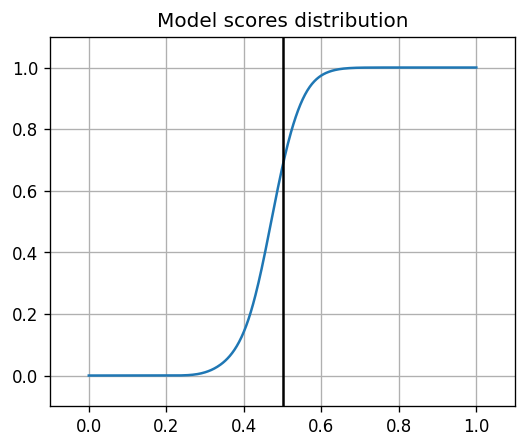

In [21]:
xs = torch.linspace(0.0, 1.0, steps = 501)
img = evaluate_image(sasrec._orig_mod.loss.cdf_image.cpu(), xs)

fig = plt.figure(figsize = (5, 4), dpi = 120)
plt.title("Model scores distribution")
plt.plot(xs, img)
plt.xlim(-0.1, +1.1)
plt.ylim(-0.1, +1.1)
plt.axvline(0.5, c = "k")
plt.grid()
plt.show()
plt.close(fig)

Now we can get the best model path stored in the checkpoint callback.

In [22]:
best_model_path = checkpoint_callback.best_model_path
best_model_path

'/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=73-step=3552.ckpt'

## Inference

To obtain model scores, we will load the weights from the best checkpoint. To do this, we use the `LightningModule`, provide there the path to the checkpoint and the model instance.

In [23]:
import replay
torch.serialization.add_safe_globals([
    replay.nn.lightning.optimizer.OptimizerFactory,
    replay.nn.lightning.scheduler.LRSchedulerFactory,
])

In [24]:
best_model = LightningModule.load_from_checkpoint(best_model_path, model=sasrec, weight_only=True)
best_model.eval()

LightningModule(
  (model): OptimizedModule(
    (_orig_mod): SasRec(
      (body): SasRecBody(
        (embedder): SequenceEmbedding(
          (feature_embedders): ModuleDict(
            (item_id): CategoricalEmbedding(
              (emb): Embedding(3707, 64, padding_idx=3706)
            )
          )
        )
        (embedding_aggregator): PositionAwareAggregator(
          (embedding_aggregator): SumAggregator()
          (pe): Embedding(50, 64)
          (dropout): Dropout(p=0.3, inplace=False)
        )
        (encoder): SasRecTransformerLayer(
          (attention_layers): ModuleList(
            (0-1): 2 x MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
            )
          )
          (attention_layernorms): ModuleList(
            (0-1): 2 x LayerNorm((64,), eps=1e-08, elementwise_affine=True)
          )
          (forward_layers): ModuleList(
            (0-1): 2 x PointWiseFeedForward(
     

Configure `ParquetModule` for inference

In [25]:
inference_metadata = {"predict": create_meta(shape=MAX_SEQ_LEN)}

parquet_module = ParquetModule(
    predict_path=PREDICT_PATH,
    batch_size=BATCH_SIZE,
    metadata=inference_metadata,
    transforms=transforms,
)

During inference, we can use `TopItemsCallback`. Such callback allows you to get scores for each user throughout the entire catalog and get recommendations in the form of ids of items with the highest score values.


Recommendations can be fetched in four formats: PySpark DataFrame, Pandas DataFrame, Polars DataFrame or raw PyTorch tensors. Each of the types corresponds a callback. In this example, we'll be using the `PandasTopItemsCallback`.

In [26]:
from replay.nn.lightning.callback import PandasTopItemsCallback

csv_logger = CSVLogger(save_dir="sasrec/logs/test", name="SasRec-example")

TOPK = [1, 5, 10, 20]

pandas_prediction_callback = PandasTopItemsCallback(
    top_k=max(TOPK),
    query_column="user_id",
    item_column="item_id",
    rating_column="score",
)

trainer = L.Trainer(callbacks=[pandas_prediction_callback], logger=csv_logger, inference_mode=True)
trainer.predict(best_model, datamodule=parquet_module, return_predictions=False)

pandas_res = pandas_prediction_callback.get_result()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [27]:
pandas_res

,user_id,item_id,score
0,0,101,9.715239
0,0,3030,7.242642
0,0,358,6.933521
0,0,3029,6.772519
0,0,1398,6.590749
...,...,...,...
6037,6039,2968,5.525061
6037,6039,2401,5.495193
6037,6039,3503,5.440112
6037,6039,2144,5.387086


### Calculating metrics

*test_gt* is already encoded, so we can use it for computing metrics.

In [28]:
from replay.metrics import MAP, OfflineMetrics, Precision, Recall
from replay.metrics.torch_metrics_builder import metrics_to_df

In [29]:
result_metrics = OfflineMetrics(
    [Recall(TOPK), Precision(TOPK), MAP(TOPK)],
    query_column="user_id",
    rating_column="score",
)(pandas_res, test_gt.explode("item_id"))

In [30]:
metrics_to_df(result_metrics)

k,1,10,20,5
MAP,0.004803,0.036125,0.043033,0.027443
Precision,0.004803,0.013995,0.011982,0.014806
Recall,0.004803,0.139947,0.239649,0.074031


Let's call the `inverse_transform` encoder's function to get the final dataframe with recommendations

In [31]:
encoder.inverse_transform(pandas_res)

,user_id,item_id,score
0,2012,104,9.715239
0,2012,3254,7.242642
0,2012,368,6.933521
0,2012,3253,6.772519
0,2012,1517,6.590749
...,...,...,...
6037,5727,3185,5.525061
6037,5727,2600,5.495193
6037,5727,3745,5.440112
6037,5727,2337,5.387086
